# Gene mutation analysis

In [49]:
import matplotlib
from matplotlib import pyplot
from statistics import median

# Make the plots used here look kinda like ggplots
pyplot.style.use("ggplot")

# Use a consistent color scheme for relating codon positions to colors
# For now, mimics ggplot default colors: https://stackoverflow.com/a/40181166
cp2color = {1: "#f8766d", 2: "#00ba38", 3: "#619cff"}

## Load JSON pileup data

Rather than download all of the ~34 GB of pileup data from Bloom, I converted it to two (technically three) JSON files:

- `seq2pos2cov.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position. This shouldn't include indels.
- `seq2pos2matches.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position, __that actually match the reference at this position__ (i.e. the number of `,` or `.` characters in the read bases pileup column). Again, this shouldn't include indels.
- `seq2uncoveredpositions.json`: Maps sequence name to a list of positions (1-indexed) that are covered by zero reads. Only 188 positions fit this description, and they're all within `scaffold_10465` (maybe they're gaps or something).

These JSON files are in total only 188 MB, which is a lot easier to download / work with than 34 GB of data!

**NOTE: positions are stored as strings due to this being roundtripped through JSON. TODO, if we store / load as ints this should fix pyplot junk with plotting spectra.**

In [2]:
import json

seq2pos2cov = {}
with open("/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/seq2pos2cov.json", "r") as jf:
    seq2pos2cov = json.load(jf)

seq2pos2matches = {}
with open("/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/seq2pos2matches.json", "r") as jf:
    seq2pos2matches = json.load(jf)

In [3]:
SEQS = ["scaffold_10465", "contig_1371", "contig_2358"]

### Utility functions

In [4]:
import pandas as pd
from statistics import mean

def histogram_of_123(one, two, three, title, xlabel="Modulo position within gene", ylabel="Frequency"):
    pyplot.bar(x=[1, 2, 3], height=[one, two, three])
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()
    
def get_pos_interval_from_gene(gene):
    try:
        start = int(gene.LeftEnd)
    except ValueError:
        # Account for the "<2" left end coordinate in one of the genes predicted
        start = int(gene.LeftEnd[1:])
        
    try:
        end = int(gene.RightEnd)
    except ValueError:
        # Account for the ">N" right end coordinate in one of the genes predicted
        end = int(gene.RightEnd[1:])

    if gene.Strand == "-":
        return range(end, start - 1, -1)
    elif gene.Strand == "+":
        return range(start, end + 1)
    else:
        raise ValueError("Unknown strand: {}".format(gene.Strand))
        
def histogram_maker(
    pseudo_variant_caller, title, val_aggregator=sum, min_gene_length=0, ylabel="Frequency", normalize=True,
    output_dict=False
):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position
            2. matches: an integer describing the number of matching reads aligned to a position
            
        Returns a number. For example, if we wanted to only count "mutations" as positions where 10% or more
        of the aligned reads didn't match, we could set a pseudo_variant_caller of
        lambda cov, matches: 1 if (matches / cov) <= 0.9 else 0 (assuming val_aggregator is left as sum).
        
    title: str
        Will be included after the seq name in every histogram.
        
    val_aggregator: function
        Used to aggregate the outputs of pseudo_variant_caller across all 1, 2, and 3 codon positions within
        all predicted genes for each seq. This defaults to the builtin sum function, which is useful if
        pseudo_variant_caller returns binary output (i.e. 0 or 1, as in the example given above); but other
        functions, such as statistics.mean or statistics.median, may be preferable depending on the context.
        
    min_gene_length: int
        All genes that are shorter than this will not be represented in the histograms. Defaults to 0, i.e.
        all genes are included. Note that this length is given in positions of DNA -- so if you want to only
        focus on genes with, say, at least 500 amino acids, then you should set min_gene_length to maybe somewhere
        around 1500 (I guess this depends on whether you count the start/stop codons as amino acids or not?).
        
    ylabel: str
        Label for the y-axis of the histogram. Defaults to "Frequency", but if you change val_aggregator then
        this should likely be changed as well. Only will be used if normalize is False.
        
    normalize: bool
        If True, figures out the max of the 1/2/3 values and normalizes them all by the max (e.g. if the three
        are [7, 10, 3], then the values are transformed to [0.7, 1, 0.3]). This makes it easier to compare
        histograms between different sequences, although this may not be needed if val_aggregator is mean.
        This also sets ylabel to "Normalized rate", ignoring whatever ylabel's default was (or even ignoring
        the already-specified ylabel). If the max value is 0 for a sequence, this'll just not draw a histogram
        for that sequence (since it'd be an empty histogram without normalization anyway...)
    """
    if normalize:
        ylabel = "Normalized rate"
    seq2gene2meanvals = {}
    for seq in SEQS:
        mgm = pd.read_csv(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/{}_mgmgenes.txt".format(seq),
            sep="\s+", skiprows=[1], index_col=0, header=0,
            names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
        )

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        seq2gene2meanvals[seq] = {}
        for gene in mgm.itertuples():
            if gene.Length < min_gene_length:
                # print("Gene {} has len {}, less than {}.".format(gene.Index, gene.Length, MIN_GENE_LENGTH))
                continue
            i = 1
            gm1 = []
            gm2 = []
            gm3 = []
            for pos in get_pos_interval_from_gene(gene):
                cov = seq2pos2cov[seq][str(pos)]
                matches = seq2pos2matches[seq][str(pos)]
                val = pseudo_variant_caller(cov, matches)
                if i == 1:
                    gm1.append(val)
                    i = 2
                elif i == 2:
                    gm2.append(val)
                    i = 3
                elif i == 3:
                    gm3.append(val)
                    i = 1
                else:
                    raise ValueError("Marcus forgot how modulos work, go yell at him pls")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")
                
            m1 += gm1
            m2 += gm2
            m3 += gm3
            # write gm1/etc so we can figure out outlier mutation genes
            # we could use another aggregator besides mean, but this is probs ok for now
            seq2gene2meanvals[seq][gene.Index] = [mean(gm1), mean(gm2), mean(gm3)]
            
        if not (len(m1) == len(m2) == len(m3)):
            raise ValueError("Imbalance in 1/2/3 positions.")
            
        vals = [val_aggregator(m1), val_aggregator(m2), val_aggregator(m3)]
        if normalize:
            max_val = max(vals)
            if max_val != 0:
                vals = [v / max_val for v in vals]
            else:
                continue
        histogram_of_123(*vals, "{}: {}".format(seq, title), ylabel=ylabel)
    if output_dict:
        return seq2gene2meanvals

### Quick check: how many genes, and how many bases within genes, are present in each of the three seqs?
Assumes that genes are non-overlapping, which should be a safe assumption.

In [5]:
for seq in SEQS:
    num_genes = 0
    bases_in_genes = 0
    mgm = pd.read_csv(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/{}_mgmgenes.txt".format(seq),
        sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
    )
    for gene in mgm.itertuples():
        num_genes += 1
        bases_in_genes += len(get_pos_interval_from_gene(gene))
    print("{}: {:,} genes, {:,} bases in genes".format(seq, num_genes, bases_in_genes))

scaffold_10465: 1,553 genes, 1,411,587 bases in genes
contig_1371: 1,630 genes, 1,499,595 bases in genes
contig_2358: 2,487 genes, 2,285,421 bases in genes


### Exactly 1 "mutation"

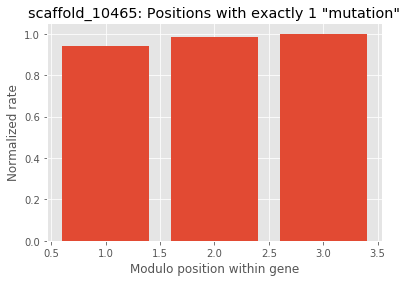

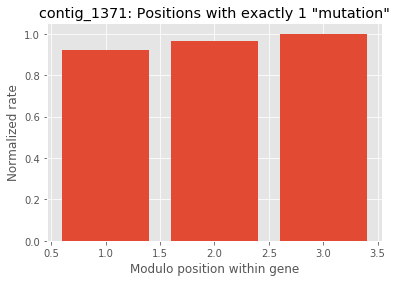

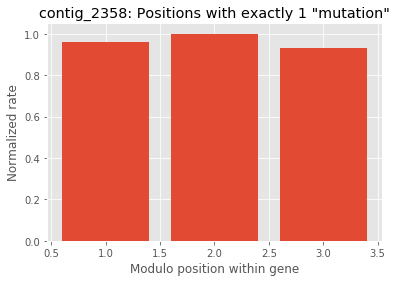

In [29]:
f = lambda cov, matches: 1 if matches == cov - 1 else 0
histogram_maker(f, 'Positions with exactly 1 "mutation"')

### Exactly 2 "mutations"

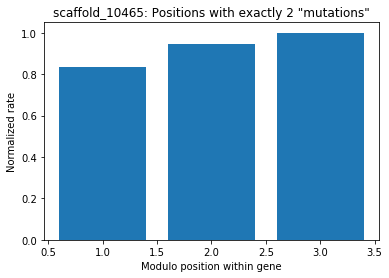

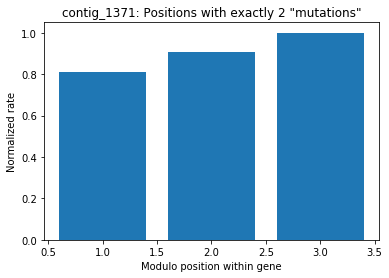

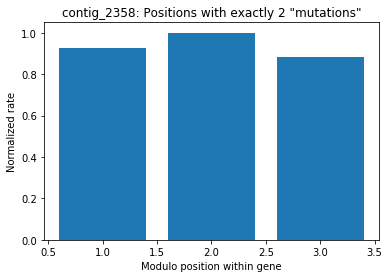

In [7]:
f = lambda cov, matches: 1 if matches == cov - 2 else 0
histogram_maker(f, 'Positions with exactly 2 "mutations"')

### Exactly 3 "mutations"

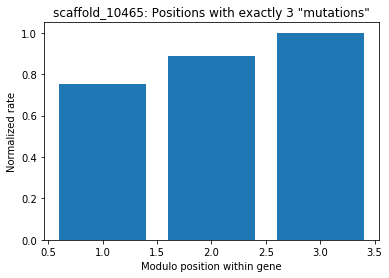

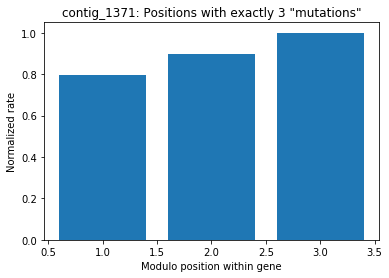

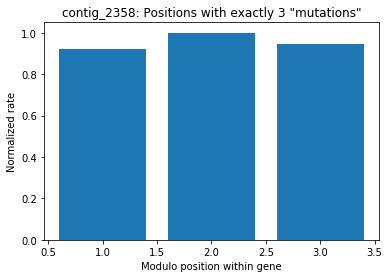

In [8]:
f = lambda cov, matches: 1 if matches == cov - 3 else 0
histogram_maker(f, 'Positions with exactly 3 "mutations"')

### Exactly 4 "mutations"

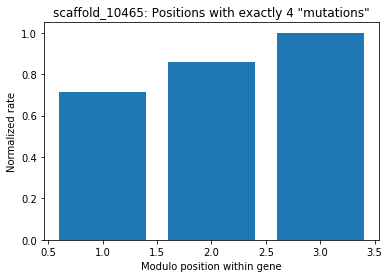

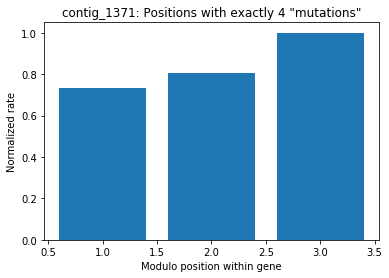

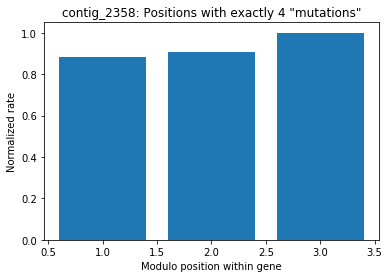

In [9]:
f = lambda cov, matches: 1 if matches == cov - 4 else 0
histogram_maker(f, 'Positions with exactly 4 "mutations"')

### At least one "mutation": normalize false, and normalize true

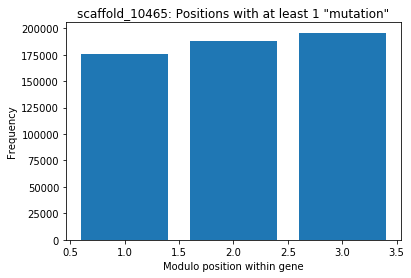

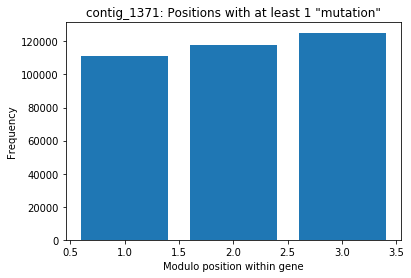

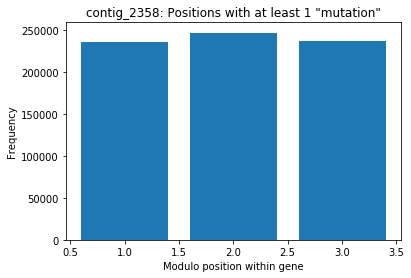

In [10]:
f = lambda cov, matches: 1 if matches < cov else 0
histogram_maker(f, 'Positions with at least 1 "mutation"', normalize=False)

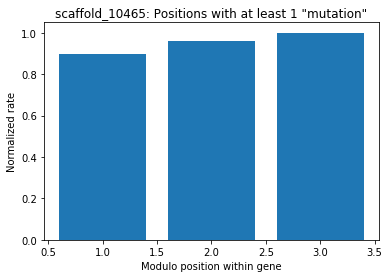

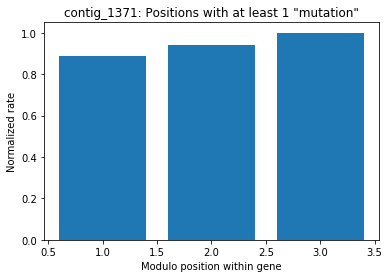

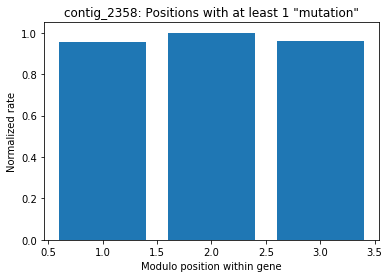

In [11]:
f = lambda cov, matches: 1 if matches < cov else 0
histogram_maker(f, 'Positions with at least 1 "mutation"', normalize=True)

### 10 or more "mutations"

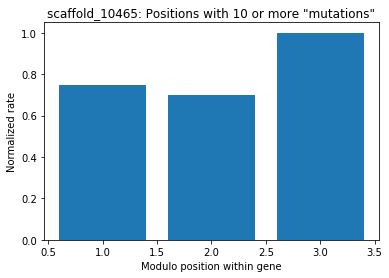

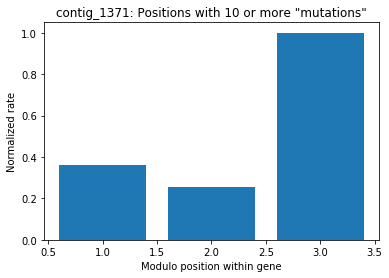

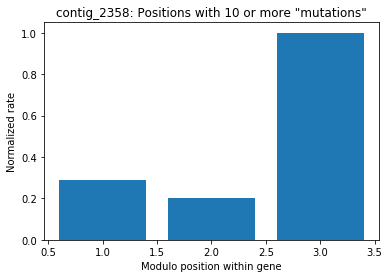

In [12]:
f = lambda cov, matches: 1 if matches <= cov - 10 else 0
histogram_maker(f, 'Positions with 10 or more "mutations"')

### 1% or more "mutations"

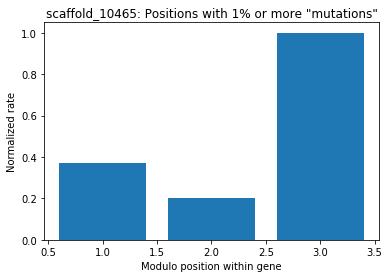

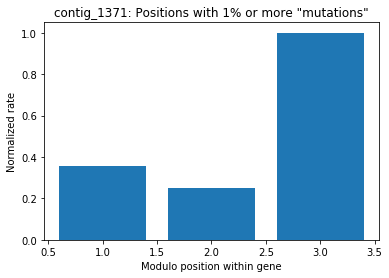

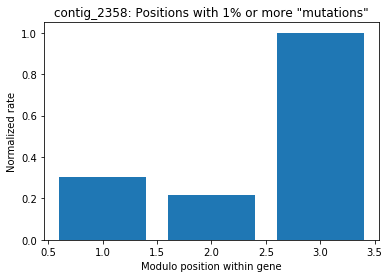

In [13]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.01 else 0
x = histogram_maker(f, 'Positions with 1% or more "mutations"')

### 1% or more "mutations", min gene length of 1500 bp

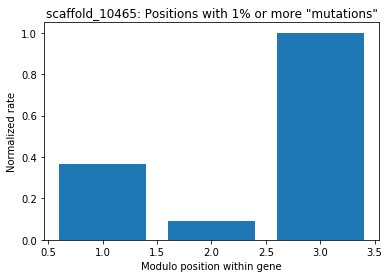

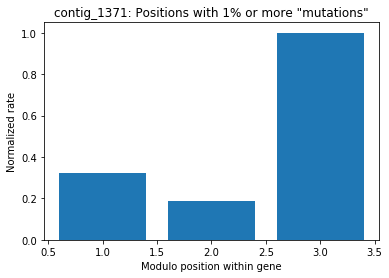

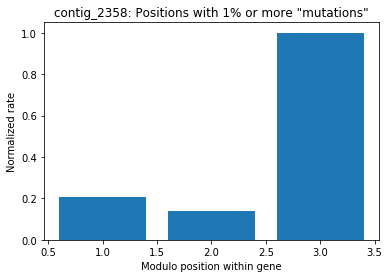

In [14]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.01 else 0
histogram_maker(f, 'Positions with 1% or more "mutations"', min_gene_length=1500)

### 10% or more "mutations"

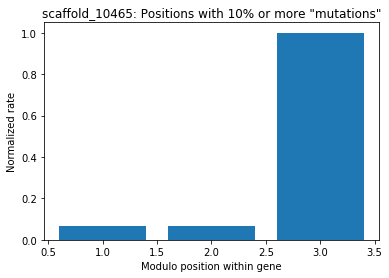

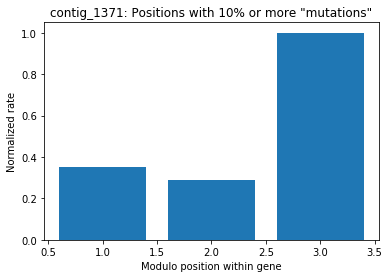

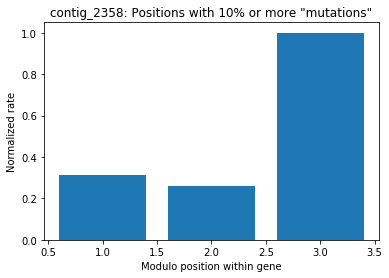

In [15]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.1 else 0
histogram_maker(f, 'Positions with 10% or more "mutations"')

### 50% or more "mutations"

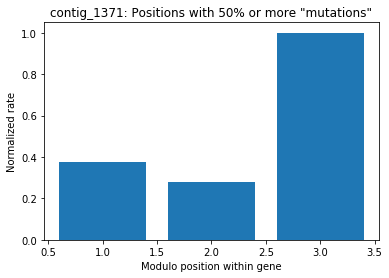

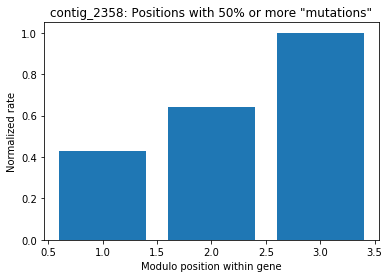

In [16]:
f = lambda cov, matches: 1 if 1 - (matches / cov) >= 0.5 else 0
histogram_maker(f, 'Positions with 50% or more "mutations"')

### Average mutation rate

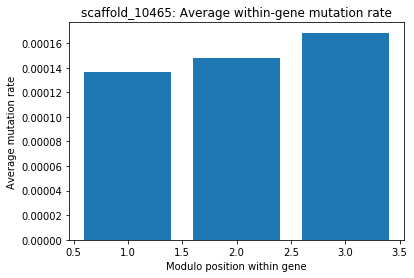

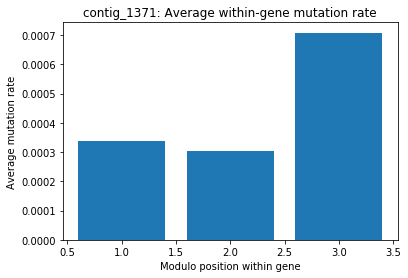

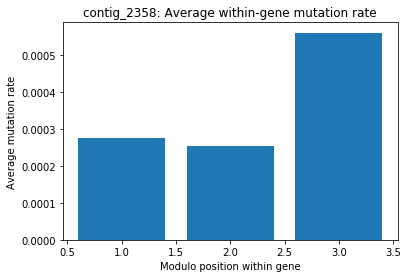

In [17]:
f = lambda cov, matches: 1 - (matches / cov)
seq2gene2rawvals = histogram_maker(f,
    "Average within-gene mutation rate", val_aggregator=mean, ylabel="Average mutation rate", normalize=False,
    output_dict=True
)

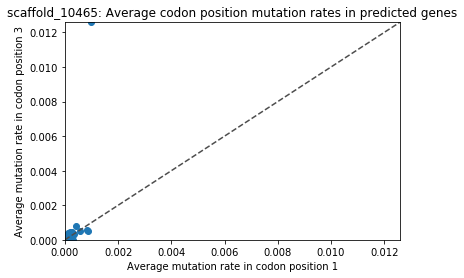

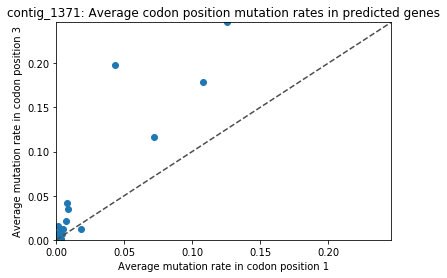

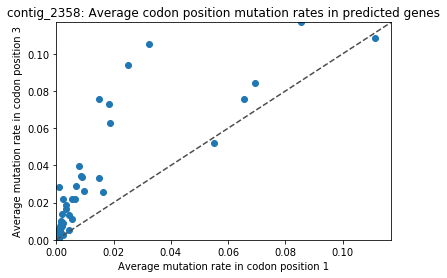

In [18]:
for seq in SEQS:
    gene2meanmutrates = seq2gene2rawvals[seq]
    gene_indices = list(gene2meanmutrates.keys())
    gene_meanmutrates = gene2meanmutrates.values()
    p1 = [v[0] for v in gene_meanmutrates]
    p2 = [v[1] for v in gene_meanmutrates]
    p3 = [v[2] for v in gene_meanmutrates]
    pyplot.title("{}: Average codon position mutation rates in predicted genes".format(seq))
    pyplot.scatter(p1, p3)
    pyplot.xlabel("Average mutation rate in codon position 1")
    pyplot.ylabel("Average mutation rate in codon position 3")
    # p1 and p3 are lists so max(p1 + p3) is a way of saying "the maximum value across both these lists"
    pyplot.xlim(0, max(p1 + p3))
    pyplot.ylim(0, max(p1 + p3))
    # Plot diagonal line: https://stackoverflow.com/a/22105008
    # Get "ax": https://stackoverflow.com/a/15067854
    pyplot.plot(pyplot.gca().get_xlim(), pyplot.gca().get_ylim(), ls="--", c=".3")
    pyplot.show()

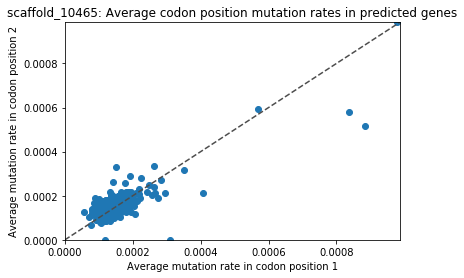

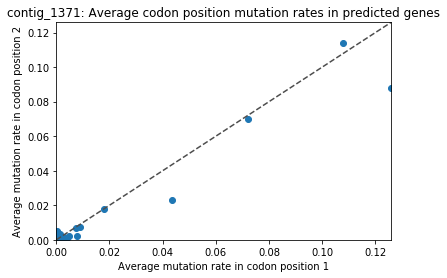

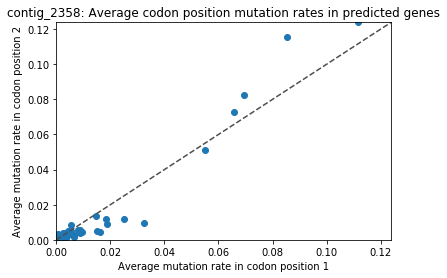

In [19]:
for seq in SEQS:
    gene2meanmutrates = seq2gene2rawvals[seq]
    gene_indices = list(gene2meanmutrates.keys())
    gene_meanmutrates = gene2meanmutrates.values()
    p1 = [v[0] for v in gene_meanmutrates]
    p2 = [v[1] for v in gene_meanmutrates]
    p3 = [v[2] for v in gene_meanmutrates]
    pyplot.title("{}: Average codon position mutation rates in predicted genes".format(seq))
    pyplot.scatter(p1, p2)
    pyplot.xlabel("Average mutation rate in codon position 1")
    pyplot.ylabel("Average mutation rate in codon position 2")
    pyplot.xlim(0, max(p2 + p1))
    pyplot.ylim(0, max(p2 + p1))
    # Plot diagonal line: https://stackoverflow.com/a/22105008
    # Get "ax": https://stackoverflow.com/a/15067854
    pyplot.plot(pyplot.gca().get_xlim(), pyplot.gca().get_ylim(), ls="--", c=".3")
    pyplot.show()

In [20]:
# Focus on specific outlier genes, manually... (ideally this would be paired with interactive plots
# using Altair or something but that installing that is hard)
seq = "scaffold_10465"
gene2meanmutrates = seq2gene2rawvals[seq]
for gene in gene2meanmutrates:
    if gene2meanmutrates[gene][2] >  0.012:
        print(gene, gene2meanmutrates[gene])

5420 [0.00097823911967833, 0.0009862980034276308, 0.012584027318359009]


## Compute mutation profiles
Number of positions with one mutation, number of positions with two mutations, etc.

In [21]:
from collections import defaultdict
import os
from math import log

def get_mutation_profile(seq):
    num_mutations_to_freq = defaultdict(int)
    for pos in seq2pos2cov[seq]:
        # ignore uncovered places. Could also ignore places with less than some threshold coverage (e.g. 5)
        if seq2pos2cov[seq][pos] == 0:
            continue
        mutct = seq2pos2cov[seq][pos] - seq2pos2matches[seq][pos]
        num_mutations_to_freq[mutct] += 1
    return num_mutations_to_freq

def view_mutation_profiles(xlim_max=None, ylim_max=None, logscale=False):
    for seq in SEQS:
        num_mutations_to_freq = get_mutation_profile(seq)
        
        # .keys() and .values() should be in the same order: https://stackoverflow.com/a/835430
        pyplot.scatter(num_mutations_to_freq.keys(), num_mutations_to_freq.values())
        
        ylabel = "How many positions have this many mutations?"
        if logscale:
            # https://stackoverflow.com/a/14530857
            pyplot.gca().set_yscale("log")
            ylabel += "\n(log$_{10}$ scale)"
        pyplot.xlabel("Number of mutations")
        pyplot.ylabel(ylabel)
        
        title = "{}: Mutation Profile".format(seq)
        
        if ylim_max is None:
            pyplot.ylim(0)
        else:
            pyplot.ylim(0, ylim_max)
            title += "\n(y-axis truncated to {})".format(ylim_max)
        if xlim_max is None:
            pyplot.xlim(0)
        else:
            pyplot.xlim(0, xlim_max)
            title += "\n(x-axis truncated to {})".format(xlim_max)
        pyplot.title(title)
        pyplot.show()
            
def save_mutation_profiles(output_dir="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph"):
    for seq in SEQS:
        num_mutations_to_freq = get_mutation_profile(seq)
        out_fn = os.path.join(output_dir, "{}_mutation_profile.tsv".format(seq))
        with open(out_fn, "w") as tsvf:
            tsvf.write("Number of mutations\tNumber of positions with exactly this many mutations\n")
            for i in range(0, max(num_mutations_to_freq.keys()) + 1):
                tsvf.write("{}\t{}\n".format(i, num_mutations_to_freq[i]))

/home/marcus/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


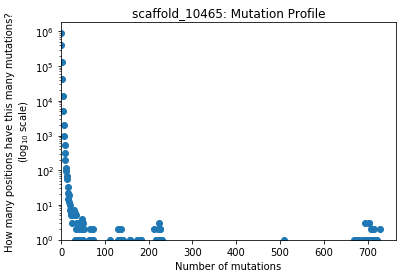

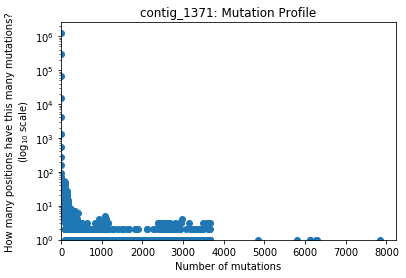

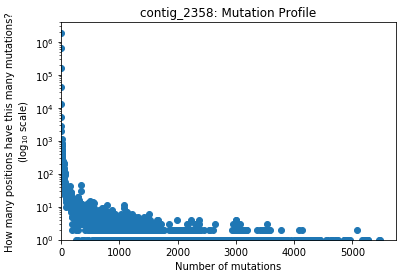

In [22]:
view_mutation_profiles(logscale=True)

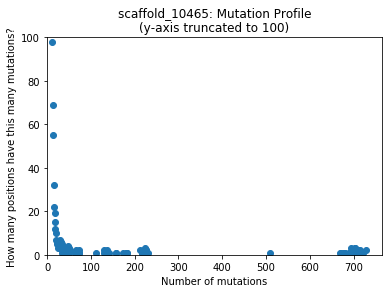

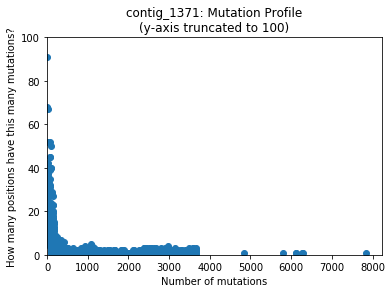

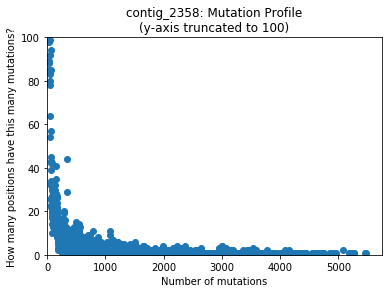

In [23]:
view_mutation_profiles(ylim_max=100)

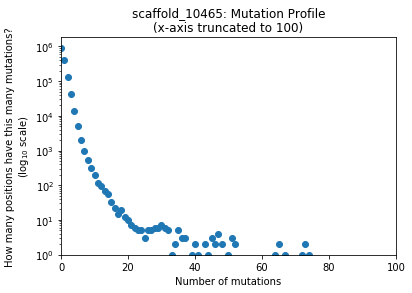

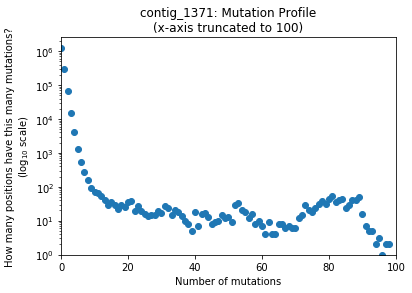

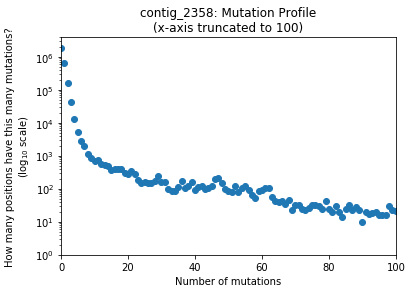

In [24]:
view_mutation_profiles(xlim_max=100, logscale=True)

In [25]:
save_mutation_profiles()

## Plot along-gene mutation rates
We're gonna go with that one wacky gene in the scaffold, for now. But could of course generalize this to other genes.

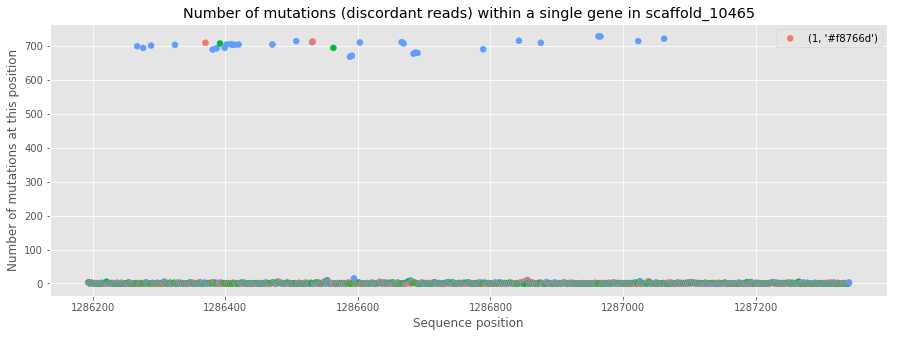

In [72]:
# The gene we're going to plot here is number 5420, which has a left end on the sequence at
# position 1,286,193 and a right end at position 1,287,341.

seq = "scaffold_10465"
leftend = 1286193
rightend = 1287341

gene_positions = range(leftend, rightend + 1)
yvals = []
covs = []
colors = []
cp = 1
for p in gene_positions:
    sp = str(p)
    num_discordant_reads = seq2pos2cov[seq][sp] - seq2pos2matches[seq][sp]
    yvals.append(num_discordant_reads)
    covs.append(seq2pos2cov[seq][sp])
    colors.append(cp2color[cp])
    if cp == 3:
        cp = 1
    else:
        cp += 1

pyplot.title("Number of mutations (discordant reads) within a single gene in scaffold_10465")
pyplot.xlabel("Sequence position")
pyplot.ylabel("Number of mutations at this position")
pyplot.scatter(gene_positions, yvals, c=colors)
pyplot.legend(cp2color.items())
# Make figure wide: https://stackoverflow.com/a/4306340
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)

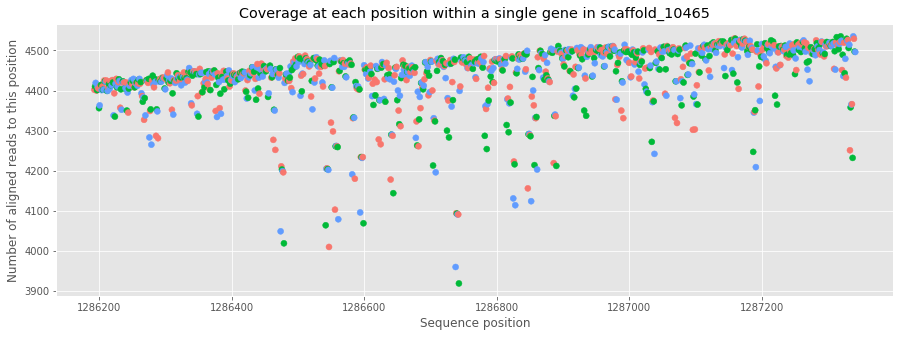

In [51]:
pyplot.title("Coverage at each position within a single gene in scaffold_10465")
pyplot.xlabel("Sequence position")
pyplot.ylabel("Number of aligned reads to this position")
pyplot.scatter(gene_positions, covs, c=colors)
# Make figure wide: https://stackoverflow.com/a/4306340
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 5)